In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install holidays
import holidays
from scipy.stats import skew
from scipy.stats import kurtosis

#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 

# from sklearn import necessary packages for naive bayes
from sklearn.preprocessing import LabelEncoder # Was getting 'NameError: name 'LabelEncoder' is not defined'
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Importing evaluation metrics

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
# Define file pathname
base = "Bike share ridership/Bike share ridership "
extension = [
    "2023-01", "2023-02", "2023-03", "2023-04", "2023-05", "2023-06",
    "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    ]

# Define columns order in a list
columns = [
    "Trip Id", "Trip Duration", "Start Station Id", "Start Time",
    "Start Station Name", "End Station Id", "End Time",
    "End Station Name", "Bike Id", "User Type"
    ]

# Used to store file paths
paths = []

# Loop through file extensions and combine them to locate them individually
for month in extension:
    path = base + month + ".csv"
    paths.append(path)

# Used to store the individual data frames
all_dfs = []

# Clean columns (Inconsistencies between 2024 and other years)
# Mismatch beteen the years issued a lot of NaN values. Trip Id was duplicated (2024 had its own).
for file in paths:
    df_temp = pd.read_csv(file, encoding = "latin1")
    df_temp.columns = [col.replace("ï»¿", "").strip() for col in df_temp.columns]

    # Used to clean BOM character for "Trip Id" (2024)
    if "ï»¿Trip Id" in df_temp.columns:
        df_temp["Trip Id"] = df_temp["ï»¿Trip Id"]
        df_temp = df_temp.drop(columns = ["ï»¿Trip Id"])

    #remove extra space in Trip Duration column
    #df.columns = df.columns.str.replace("Trip  Duration", "Trip Duration")
    df_temp.rename(columns={"Trip  Duration": "Trip Duration"}, inplace=True)

    # Reindexes the data frame according to columns list.
    df_temp = df_temp.reindex(columns = columns)
    all_dfs.append(df_temp)

# Concatinate dataframe
df = pd.concat(all_dfs, ignore_index = True)

# Drop "Model" to stay consistent with previous years (Only present in 2024)
df = df.drop(columns = ["Model", "Bike Id"], errors = "ignore")


df = df.set_index("Trip Id")

# NEXT STEPS: Look into Start Station Name and End Station Name.


In [4]:
df.columns.tolist()

['Trip Duration',
 'Start Station Id',
 'Start Time',
 'Start Station Name',
 'End Station Id',
 'End Time',
 'End Station Name',
 'User Type']

In [5]:
print(f"Start Station Name: {df['Start Station Name'].nunique()}")
print(f"End Station Name: {df['End Station Name'].nunique()}")

Start Station Name: 593
End Station Name: 592


In [6]:
df.isna().sum()

Trip Duration              0
Start Station Id           0
Start Time                 0
Start Station Name    595075
End Station Id          2944
End Time                   0
End Station Name      598563
User Type                  0
dtype: int64

In [7]:
### START TIME
#split start time into 2 columns
df[['Start Date', 'Start Time']] = df['Start Time'].str.split(' ', expand=True)

#move start date to the 3rd index
col = df.pop('Start Date')
df.insert(3, col.name, col)

#convert date to datetime format
df['Start Date'] = pd.to_datetime(df['Start Date'], format = '%m/%d/%Y')

In [8]:
### END TIME
#split start time into 2 columns
df[['End Date', 'End Time']] = df['End Time'].str.split(' ', expand=True)

#move start date to the 3rd index
col = df.pop('End Date')
df.insert(3, col.name, col)

#convert date to datetime format
df['End Date'] = pd.to_datetime(df['End Date'], format = '%m/%d/%Y')

In [9]:
### START TIME
#split date into day/month but keep og column
df['Start Day'] = df['Start Date'].dt.day

df['Start Month'] = df['Start Date'].dt.month

#move start day to the 4th index
col = df.pop('Start Day')
df.insert(4, col.name, col)

#move start month to the 5th index
col = df.pop('Start Month')
df.insert(5, col.name, col)


#change trip duration to minutes/hours
def convert(seconds):
    seconds = seconds % (24 * 60 * 60)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)


#df['Trip Duration'] = df['Trip Duration'].apply(convert)
df.tail()

,Trip Duration,Start Station Id,Start Time,End Date,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type
Trip Id,,,,,,,,,,,,
26682732,185,7391,23:56,2023-12-31,31,12,2023-12-31,Yonge St / Dundas Sq,7041.0,23:59,Edward St / Yonge St,Casual Member
26682733,802,7366,23:56,2024-01-01,31,12,2023-12-31,Fort York Blvd / Bathurst St SMART,7048.0,00:10,Front St W / Yonge St (Hockey Hall of Fame),Casual Member
26682735,1314,7203,23:57,2024-01-01,31,12,2023-12-31,Bathurst St/Queens Quay(Billy Bishop Airport),7719.0,00:19,NaN,Casual Member
26682737,371,7788,23:58,2024-01-01,31,12,2023-12-31,NaN,7788.0,00:05,NaN,Casual Member
26682738,1271,7298,23:59,2024-01-01,31,12,2023-12-31,Bathurst St / Adelaide St W,7075.0,00:21,Queens Quay W / Dan Leckie Way,Casual Member


In [10]:
### END TIME
#split date into day/month but keep og column
df['End Day'] = df['End Date'].dt.day

df['End Month'] = df['End Date'].dt.month

#move start day to the 4th index
col = df.pop('End Day')
df.insert(4, col.name, col)

#move start month to the 5th index
col = df.pop('End Month')
df.insert(5, col.name, col)


#change trip duration to minutes/hours
def convert(seconds):
    seconds = seconds % (24 * 60 * 60)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)


#df['Trip Duration'] = df['Trip Duration'].apply(convert)
df.tail()

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type
Trip Id,,,,,,,,,,,,,,
26682732,185,7391,23:56,2023-12-31,31,12,31,12,2023-12-31,Yonge St / Dundas Sq,7041.0,23:59,Edward St / Yonge St,Casual Member
26682733,802,7366,23:56,2024-01-01,1,1,31,12,2023-12-31,Fort York Blvd / Bathurst St SMART,7048.0,00:10,Front St W / Yonge St (Hockey Hall of Fame),Casual Member
26682735,1314,7203,23:57,2024-01-01,1,1,31,12,2023-12-31,Bathurst St/Queens Quay(Billy Bishop Airport),7719.0,00:19,NaN,Casual Member
26682737,371,7788,23:58,2024-01-01,1,1,31,12,2023-12-31,NaN,7788.0,00:05,NaN,Casual Member
26682738,1271,7298,23:59,2024-01-01,1,1,31,12,2023-12-31,Bathurst St / Adelaide St W,7075.0,00:21,Queens Quay W / Dan Leckie Way,Casual Member


In [11]:
#create weekday/weekend column
df['Weekday/Weekend'] = df['Start Date'].dt.weekday.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

df.head()

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend
Trip Id,,,,,,,,,,,,,,,
20148784,840,7022,00:00,2023-01-01,1,1,1,1,2023-01-01,Simcoe St / Queen St W,7703.0,00:14,NaN,Casual Member,Weekend
20148785,722,7399,00:01,2023-01-01,1,1,1,1,2023-01-01,Lower Jarvis / Queens Quay E,7533.0,00:13,Housey St / Dan Leckie Way,Casual Member,Weekend
20148786,1054,7269,00:02,2023-01-01,1,1,1,1,2023-01-01,Toronto Eaton Centre (Yonge St),7076.0,00:20,York St / Queens Quay W,Annual Member,Weekend
20148790,1329,7721,00:04,2023-01-01,1,1,1,1,2023-01-01,NaN,7685.0,00:26,NaN,Casual Member,Weekend
20148791,1291,7721,00:04,2023-01-01,1,1,1,1,2023-01-01,NaN,7685.0,00:26,NaN,Casual Member,Weekend


In [12]:
# Checking if the Weekday/Weekend column is correct in July
df[(df['Weekday/Weekend'] == 'Weekend') & (df['Start Date'].dt.year == 2023) & (df['Start Date'].dt.month == 7)].sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend
Trip Id,,,,,,,,,,,,,,,
23303327,1077,7184,18:20,2023-07-23,23,7,23,7,2023-07-23,Ossington Ave / College St,7054.0,18:38,Navy Wharf Ct. / Bremner Blvd.,Casual Member,Weekend
23072742,531,7073,13:08,2023-07-15,15,7,15,7,2023-07-15,Spadina Ave / Fort York Blvd,7772.0,13:17,NaN,Casual Member,Weekend
22877696,524,7121,11:30,2023-07-08,8,7,8,7,2023-07-08,Jarvis St / Dundas St E,7022.0,11:39,Simcoe St / Queen St W,Casual Member,Weekend
22720421,149,7350,05:00,2023-07-02,2,7,2,7,2023-07-02,Broadview Ave / Westwood Ave,7350.0,05:03,Broadview Ave / Westwood Ave,Casual Member,Weekend
23266371,1754,7168,13:23,2023-07-22,22,7,22,7,2023-07-22,Queens Quay / Yonge St,7534.0,13:52,Walnut Ave / Queen St W,Casual Member,Weekend
22910948,2966,7329,15:06,2023-07-09,9,7,9,7,2023-07-09,Crawford St / Queen St W,7403.0,15:55,Lascelles Blvd / Eglinton Ave W,Casual Member,Weekend
23087824,1051,7207,07:41,2023-07-16,16,7,16,7,2023-07-16,Dundas St W / Crawford St,7269.0,07:59,Toronto Eaton Centre (Yonge St),Casual Member,Weekend
23478196,1006,7391,11:16,2023-07-30,30,7,30,7,2023-07-30,Yonge St / Dundas Sq,7046.0,11:32,Niagara St / Richmond St W,Casual Member,Weekend
22884293,1342,7391,14:45,2023-07-08,8,7,8,7,2023-07-08,Yonge St / Dundas Sq,7542.0,15:08,Queen St W / John St,Casual Member,Weekend


In [13]:
# Added a new column Trip Duration (mm:ss)
df['Trip Duration (mm:ss)'] = df['Trip Duration'].apply(lambda x: f"{x // 60}:{x % 60:02d}")

df.sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend,Trip Duration (mm:ss)
Trip Id,,,,,,,,,,,,,,,,
23112599,224,7001,23:47,2023-07-16,16,7,16,7,2023-07-16,Wellesley Station Green P,7044.0,23:50,Church St / Alexander St,Casual Member,Weekend,3:44
21345740,485,7506,19:49,2023-05-06,6,5,6,5,2023-05-06,Berkeley St / Adelaide St E - SMART,7399.0,19:58,Lower Jarvis / Queens Quay E,Casual Member,Weekend,8:05
25166232,778,7398,16:08,2023-09-27,27,9,27,9,2023-09-27,York St / Lakeshore St W - South,7211.0,16:21,Fort York Blvd / Garrison Rd,Casual Member,Weekday,12:58
24306236,452,7211,17:56,2023-08-28,28,8,28,8,2023-08-28,Fort York Blvd / Garrison Rd,7790.0,18:03,NaN,Casual Member,Weekday,7:32
24659775,734,7278,02:36,2023-09-10,10,9,10,9,2023-09-10,Mallon Ave / Jones Ave -SMART,7106.0,02:48,Mill St / Tannery Rd,Casual Member,Weekend,12:14
24822799,473,7130,18:22,2023-09-15,15,9,15,9,2023-09-15,Davenport Rd / Bedford Rd,7061.0,18:30,Dalton Rd / Bloor St W,Casual Member,Weekday,7:53
23005975,705,7121,22:52,2023-07-12,12,7,12,7,2023-07-12,Jarvis St / Dundas St E,7121.0,23:04,Jarvis St / Dundas St E,Casual Member,Weekday,11:45
25548206,944,7041,10:28,2023-10-13,13,10,13,10,2023-10-13,Edward St / Yonge St,7682.0,10:43,NaN,Casual Member,Weekday,15:44
21215598,1604,7253,18:21,2023-04-27,27,4,27,4,2023-04-27,John St / Mercer St - SMART,7175.0,18:48,HTO Park (Queens Quay W),Casual Member,Weekday,26:44


In [14]:
# Lists that determine what we defined as peak hours
peak_morning = [6, 7, 8, 9]
peak_evening = [15, 16, 17, 18, 19]

# Assign hour the 'Start Time' hour
hours = pd.to_datetime(df['Start Time'], format='%H:%M').dt.hour

# Defined list for a cleaner code 
conditions = [hours.isin(peak_morning), hours.isin(peak_evening)]
choices = ["Morning", "Evening"]

df['Peak Hour'] = np.select(conditions, choices, default = "Off Peak")
df_new = df
df.sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend,Trip Duration (mm:ss),Peak Hour
Trip Id,,,,,,,,,,,,,,,,,
23885536,1004,7203,15:47,2023-08-13,13,8,13,8,2023-08-13,Bathurst St/Queens Quay(Billy Bishop Airport),7101.0,16:03,Lower Sherbourne St / The Esplanade,Casual Member,Weekend,16:44,Evening
23103903,1523,7253,17:47,2023-07-16,16,7,16,7,2023-07-16,John St / Mercer St - SMART,7344.0,18:13,Cherry Beach,Casual Member,Weekend,25:23,Evening
21124591,967,7097,17:47,2023-04-21,21,4,21,4,2023-04-21,Riverdale Park North (Broadview Ave),7406.0,18:03,Victoria St / Queen St E,Casual Member,Weekday,16:07,Evening
24479399,963,7077,17:28,2023-09-03,3,9,3,9,2023-09-03,College Park South,7236.0,17:44,Thompson St / Broadview Ave - SMART,Casual Member,Weekend,16:03,Evening
23319652,1490,7569,14:06,2023-07-24,24,7,24,7,2023-07-24,Toronto Inukshuk Park,7501.0,14:31,Humberside Grounds - SMART,Casual Member,Weekday,24:50,Off Peak
22361009,906,7384,13:58,2023-06-18,18,6,18,6,2023-06-18,Cumberland Ave / Bay St SMART,7094.0,14:13,Chester Station,Casual Member,Weekend,15:06,Off Peak
24614993,3551,7816,15:19,2023-09-08,8,9,8,9,2023-09-08,NaN,7198.0,16:18,Queen St W / Cowan Ave,Casual Member,Weekday,59:11,Evening
25773232,122,7066,17:20,2023-10-23,23,10,23,10,2023-10-23,Willcocks St / St. George St,7762.0,17:22,NaN,Casual Member,Weekday,2:02,Evening
23559143,917,7095,22:02,2023-08-01,1,8,1,8,2023-08-01,Danforth Ave / Ellerbeck St,7109.0,22:18,Seaton St / Dundas St E - SMART,Casual Member,Weekday,15:17,Off Peak


In [15]:
df.columns.tolist()

['Trip Duration',
 'Start Station Id',
 'Start Time',
 'End Date',
 'End Day',
 'End Month',
 'Start Day',
 'Start Month',
 'Start Date',
 'Start Station Name',
 'End Station Id',
 'End Time',
 'End Station Name',
 'User Type',
 'Weekday/Weekend',
 'Trip Duration (mm:ss)',
 'Peak Hour']

In [16]:
order = ['Trip Duration', 'Trip Duration (mm:ss)', 
         'Start Station Id', 'Start Station Name', 'Start Time', 'Start Day', 'Start Month', 'Start Date', 
         'End Station Id', 'End Station Name', 'End Time', 'End Day', 'End Month', 'End Date',
         'User Type', 'Weekday/Weekend', 'Peak Hour']

df = df[order]
#df = df.drop(columns = ["Trip Duration"], errors = "ignore")
df.sample(10)

,Trip Duration,Trip Duration (mm:ss),Start Station Id,Start Station Name,Start Time,Start Day,Start Month,Start Date,End Station Id,End Station Name,End Time,End Day,End Month,End Date,User Type,Weekday/Weekend,Peak Hour
Trip Id,,,,,,,,,,,,,,,,,
21780846,504,8:24,7056,Parliament St / Gerrard St,15:53,26,5,2023-05-26,7475.0,Jarvis St / Richmond St E,16:01,26,5,2023-05-26,Annual Member,Weekday,Evening
25498355,387,6:27,7411,Little Norway Park,09:27,11,10,2023-10-11,7043.0,Queens Quay W / Lower Simcoe St,09:33,11,10,2023-10-11,Casual Member,Weekday,Morning
20408641,1149,19:09,7713,NaN,20:58,8,2,2023-02-08,7391.0,Yonge St / Dundas Sq,21:17,8,2,2023-02-08,Casual Member,Weekday,Off Peak
23307746,4763,79:23,7100,Dundas St E / Regent Park Blvd,21:53,23,7,2023-07-23,7693.0,NaN,23:12,23,7,2023-07-23,Casual Member,Weekend,Off Peak
26555861,2580,43:00,7256,Vanauley St / Queen St W - SMART,18:55,14,12,2023-12-14,7069.0,Queen St W / Spadina Ave,19:38,14,12,2023-12-14,Casual Member,Weekday,Evening
24846842,747,12:27,7339,Carlaw Ave / Strathcona Ave,15:12,16,9,2023-09-16,7114.0,Carlton St / Parliament St,15:25,16,9,2023-09-16,Casual Member,Weekend,Evening
22341349,1614,26:54,7549,439 Sherbourne St,18:14,17,6,2023-06-17,7043.0,Queens Quay W / Lower Simcoe St,18:41,17,6,2023-06-17,Casual Member,Weekend,Evening
20705453,368,6:08,7118,King St W / Bay St (East Side),17:14,21,3,2023-03-21,7006.0,Bay St / College St (East Side),17:20,21,3,2023-03-21,Casual Member,Weekday,Evening
21756121,2055,34:15,7251,The Royal Ontario Museum (Bloor St Entrance),15:39,25,5,2023-05-25,7581.0,High Park Ave / Dundas St W,16:13,25,5,2023-05-25,Casual Member,Weekday,Evening


In [17]:
# reset numeric variable to categorical
df['Start Station Id']=df['Start Station Id'].astype('category')
df['End Station Id']=df['End Station Id'].astype('category')
df['Start Day']=df['Start Day'].astype('category')
df['End Day']=df['End Day'].astype('category')
df['Start Month']=df['Start Month'].astype('category')
df['End Month']=df['End Month'].astype('category')

In [18]:
# calculate summary statistics

def summary_stats(column):
    # remove na values
    series = column.dropna()

    return {
        "mean": series.mean()/ 60,
        "median": series.median() /60,
        "mode": (series.mode()/60).tolist(),  # Could be multiple modes
        "std_dev": series.std()/ 60
    }

#Trip_summary = summary_stats(df, 'Trip Duration (mm:ss)')

trip_summary = summary_stats(df['Trip Duration'])

print(trip_summary)


{'mean': np.float64(17.98991376780887), 'median': np.float64(11.45), 'mode': [7.2], 'std_dev': np.float64(146.63290742720739)}


In [19]:
# function to find outliers using z-score
def find_outliers_zscore(column, threshold=3):
    # remove na values
    series = column.dropna()
    
    mean = series.mean()/60
    std = series.std()/60
    
    z_scores = (series/60 - mean) / std

        # boolean mask
    mask = np.abs(z_scores) > threshold

    # return list of outlier values
    return series[mask].tolist()



outliers = find_outliers_zscore(df["Trip Duration"])

# proportion of outliers
num_outliers = df['Trip Duration'].isin(outliers).sum()
proportion_outliers = num_outliers / len(df)

print(proportion_outliers)


0.0009920987421805274


In [20]:
# remove outliers

# replace outliers with NaN
df['Trip Duration'] = df['Trip Duration'].mask(df['Trip Duration'].isin(outliers), np.nan)

# drop rows where Trip Duration is NaN
df = df.dropna(subset=['Trip Duration']).reset_index(drop=True)

In [21]:
# calculate summary statistics

def summary_stats(column):
    # remove na values
    series = column.dropna()

    return {
        "mean": series.mean()/ 60,
        "median": series.median() /60,
        "mode": (series.mode()/60).tolist(),  # Could be multiple modes
        "std_dev": series.std()/ 60
    }

trip_summary = summary_stats(df['Trip Duration'])

print(trip_summary)


{'mean': np.float64(15.847835565757384), 'median': np.float64(11.45), 'mode': [7.2], 'std_dev': np.float64(18.41774166455083)}


In [22]:
# group by 'peak/offpeak' and apply summary_stats
trip_summary_by_peak = df.groupby('Peak Hour')['Trip Duration'].apply(summary_stats)

print(trip_summary_by_peak)

Peak Hour         
Evening    mean                   16.632388
           median                     12.05
           mode                       [7.8]
           std_dev                18.421291
Morning    mean                   12.770837
           median                      10.3
           mode       [0.03333333333333333]
           std_dev                 13.49441
Off Peak   mean                   16.177246
           median                 11.366667
           mode                       [7.2]
           std_dev                19.738693
Name: Trip Duration, dtype: object


In [23]:
# group by 'peak/offpeak' and apply summary_stats
trip_summary_by_peak = df.groupby('Start Month')['Trip Duration'].apply(summary_stats)

print(trip_summary_by_peak)

Start Month         
1            mean                    12.79995
             median                       9.9
             mode       [0.03333333333333333]
             std_dev                13.129628
2            mean                   13.449612
             median                 10.416667
             mode         [7.466666666666667]
             std_dev                13.672272
3            mean                   13.233047
             median                      10.3
             mode         [5.816666666666666]
             std_dev                13.008713
4            mean                    15.65183
             median                      11.2
             mode         [7.033333333333333]
             std_dev                17.932853
5            mean                   17.645312
             median                 12.316667
             mode         [7.416666666666667]
             std_dev                21.099279
6            mean                   17.102112
             

/var/folders/dv/8f4r5dp50yv_lywv_s27_ncw0000gn/T/ipykernel_48877/1759528924.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_summary_by_peak = df.groupby('Start Month')['Trip Duration'].apply(summary_stats)


In [24]:
# calculate proportion of missing values in dataset
def missing_proportion(df):
# return proportion of missing values
    return df.isna().mean()

missing_prop = missing_proportion(df)

print(missing_prop)

Trip Duration            0.000000
Trip Duration (mm:ss)    0.000000
Start Station Id         0.000000
Start Station Name       0.104146
Start Time               0.000000
Start Day                0.000000
Start Month              0.000000
Start Date               0.000000
End Station Id           0.000508
End Station Name         0.104727
End Time                 0.000000
End Day                  0.000000
End Month                0.000000
End Date                 0.000000
User Type                0.000000
Weekday/Weekend          0.000000
Peak Hour                0.000000
dtype: float64


In [25]:
# run skew and kurtosis
def skew_kurtosis_all(df):
    numeric_df = df.select_dtypes(include=['number'])

    return pd.DataFrame({
        "skew": numeric_df.skew(),
        "kurtosis": numeric_df.kurtosis()
    })

skew_kurtosis_df = skew_kurtosis_all(df)

print(skew_kurtosis_df)

                   skew   kurtosis
Trip Duration  7.417947  99.025541


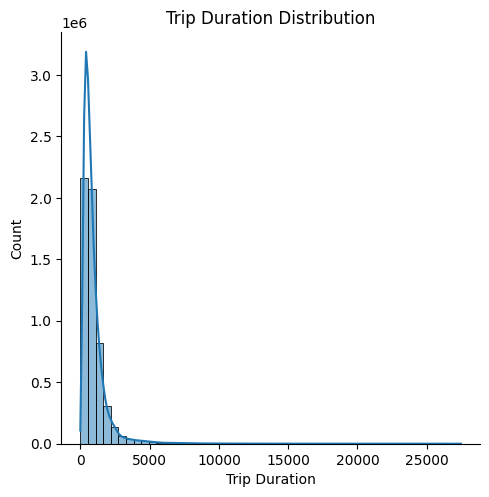

In [26]:
# visualize the distribution of the numeric variables

#plot trip duration
sns.displot(data=df, x='Trip Duration', kind='hist', kde='show', bins = 50)
plt.title('Trip Duration Distribution')

plt.show()

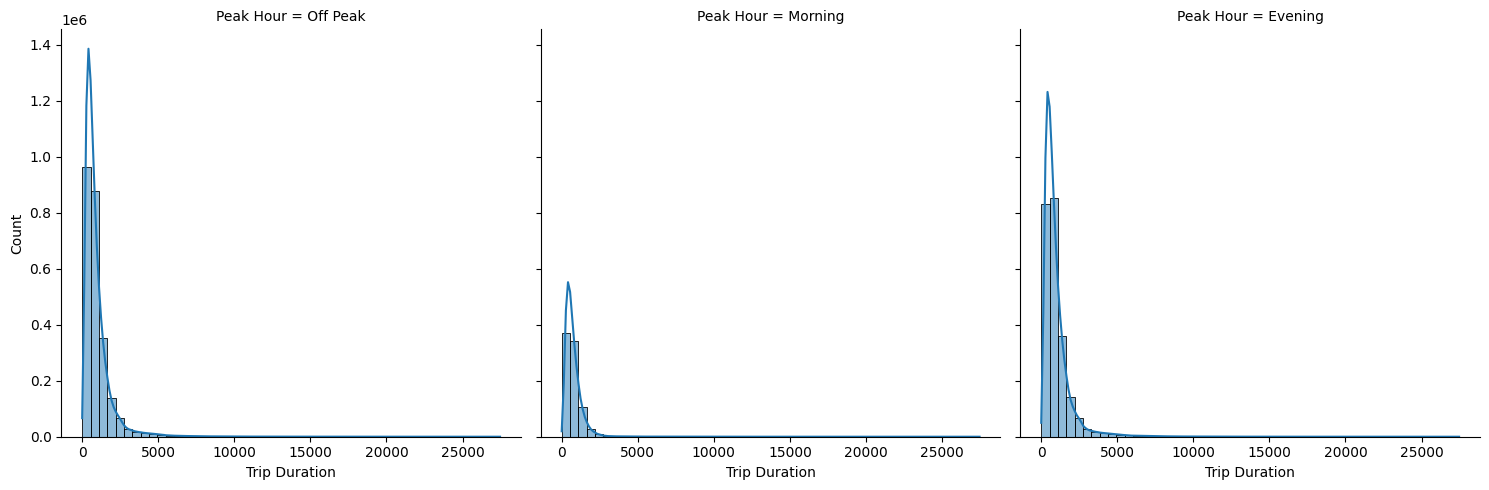

In [27]:
#plot 
sns.displot(data=df, x='Trip Duration', col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

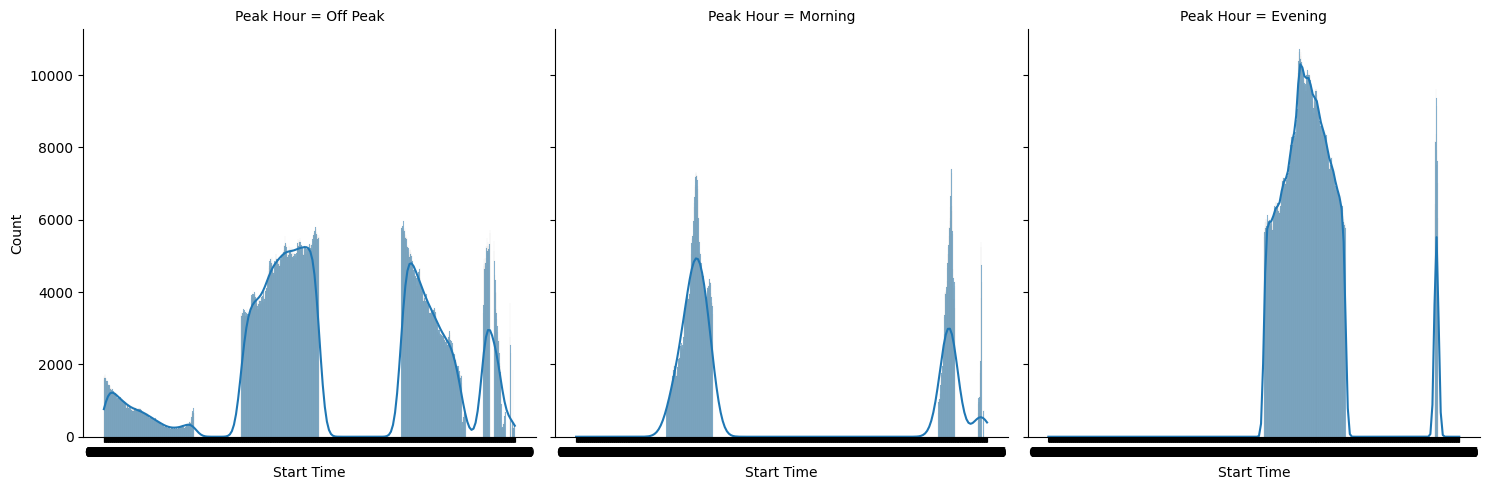

In [28]:
#plot 
sns.displot(data=df, x='Start Time', col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

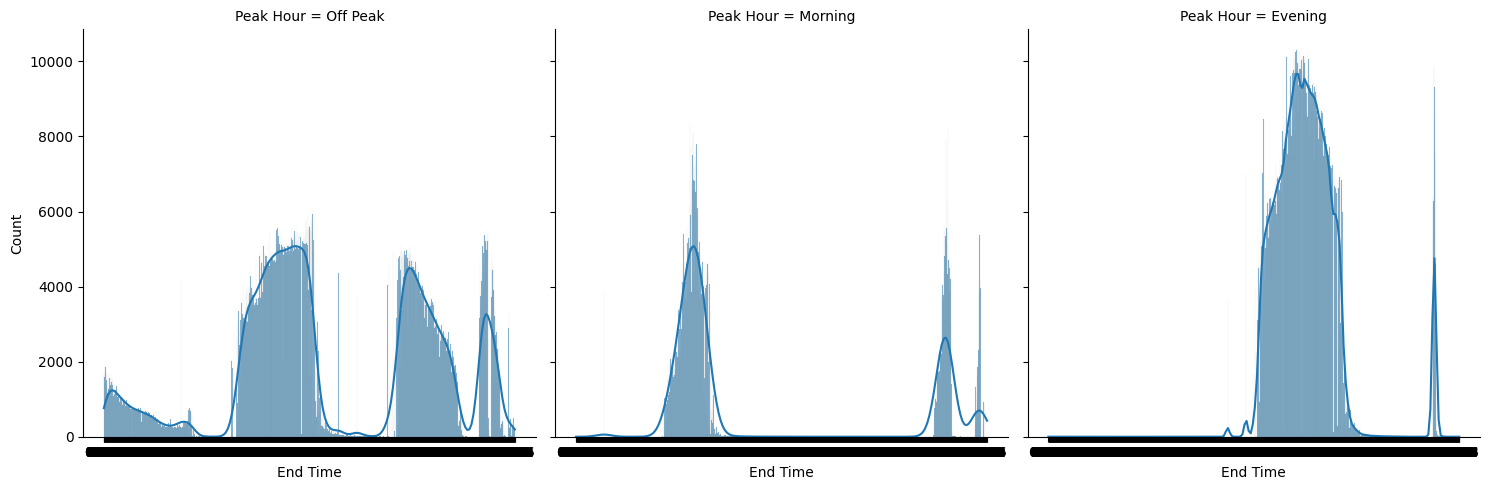

In [29]:
#plot 
sns.displot(data=df, x='End Time',col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

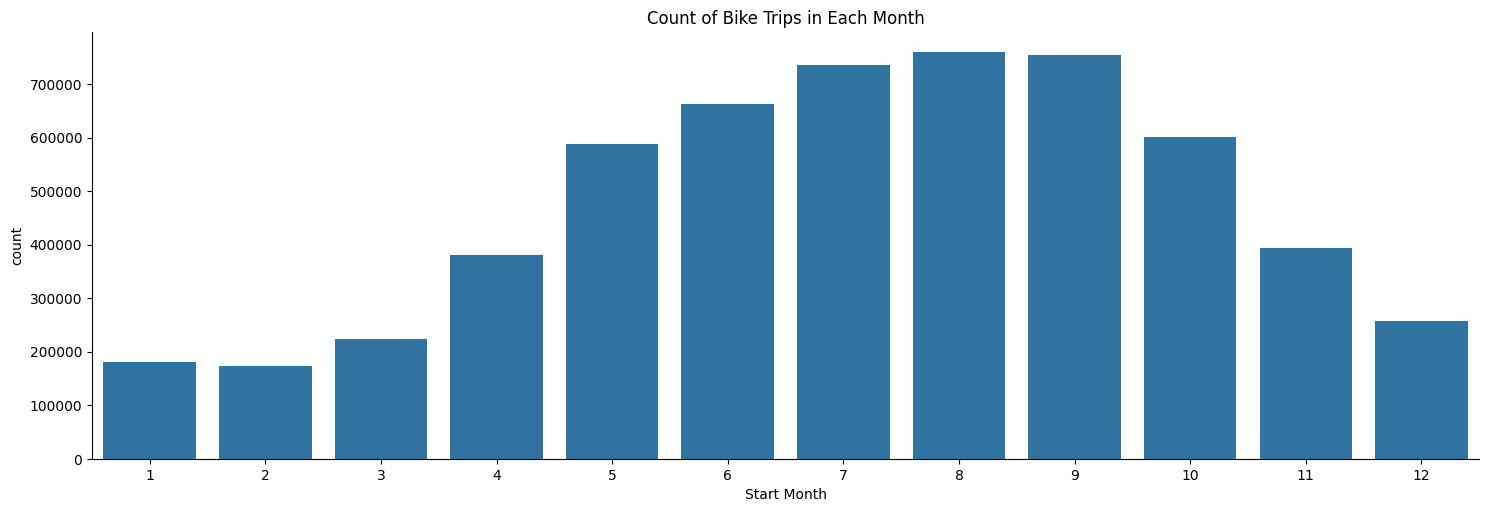

In [30]:
# plot categorical variable
sns.catplot(data=df, x='Start Month', kind='count', aspect = 3)
plt.title('Count of Bike Trips in Each Month')

plt.show()

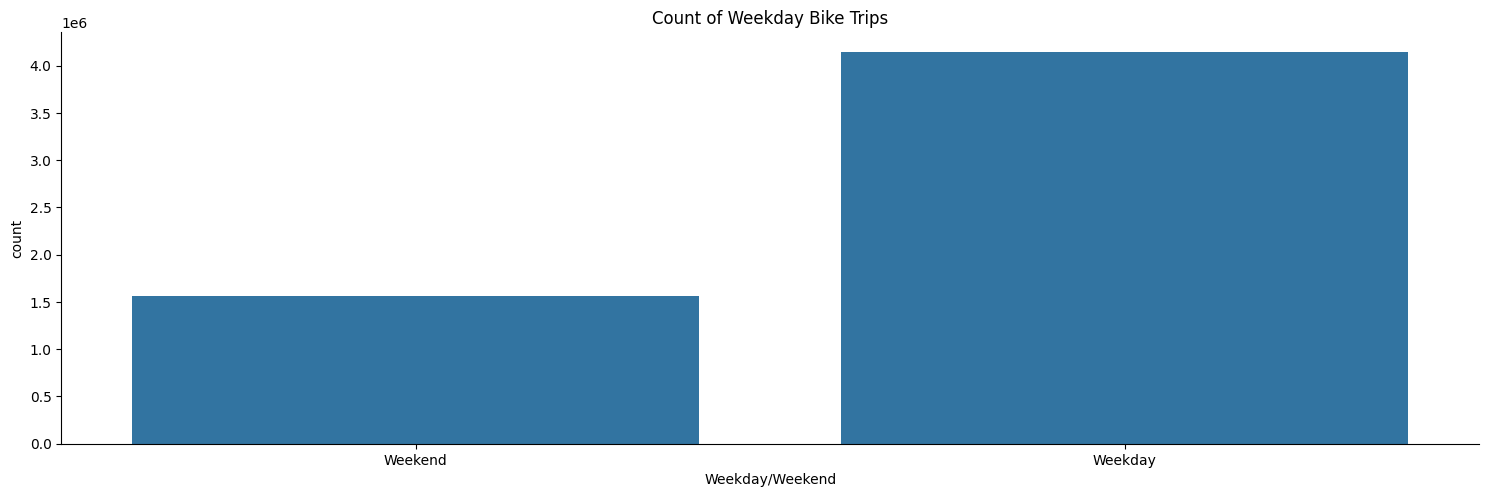

In [31]:
# plot categorical variable
sns.catplot(data=df, x='Weekday/Weekend', kind='count', aspect = 3)
plt.title('Count of Weekday Bike Trips')

plt.show()

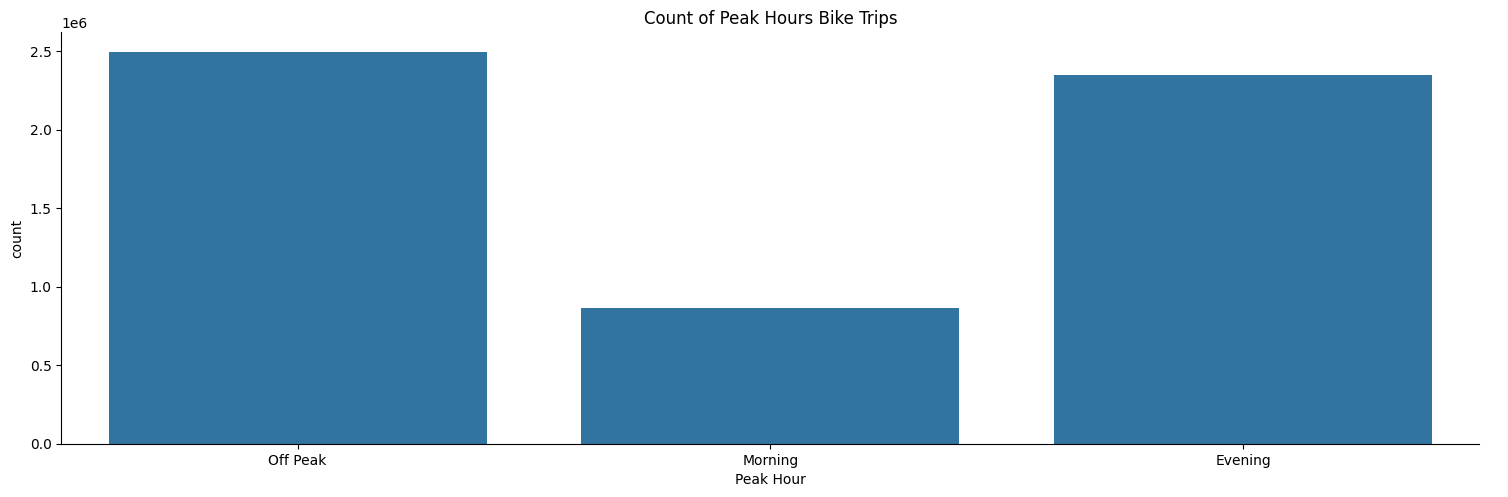

In [32]:
# plot categorical variable
sns.catplot(data=df, x='Peak Hour', kind='count', aspect = 3)
plt.title('Count of Peak Hours Bike Trips')

plt.show()

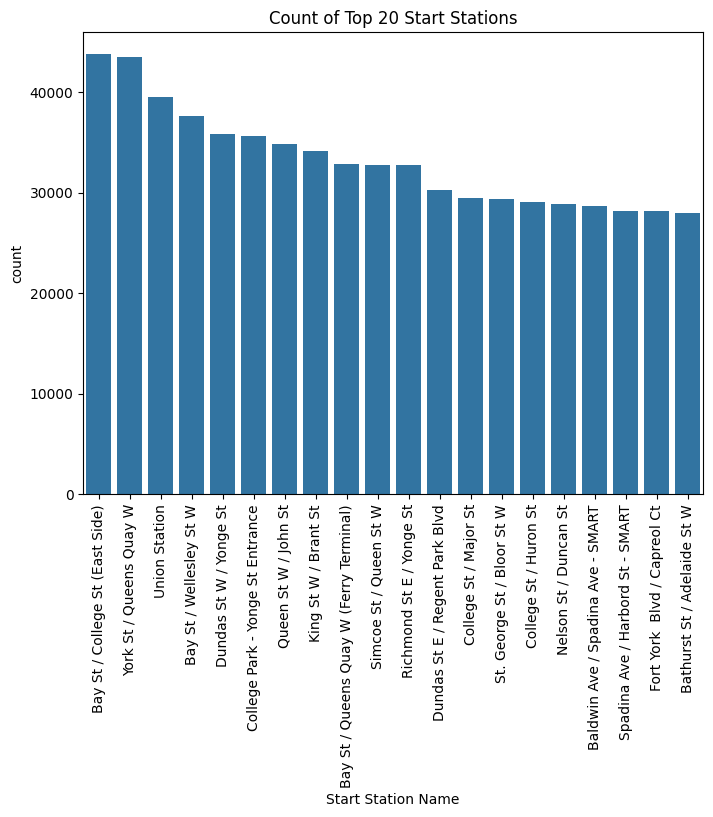

In [33]:
top_20_Stations = df['Start Station Name'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top N categories
df_top_20 = df[df['Start Station Name'].isin(top_20_Stations)]

# Create the countplot, ordering by frequency
plt.figure(figsize=(8, 6))
sns.countplot(data=df_top_20, x='Start Station Name', order=top_20_Stations)
plt.title('Count of Top 20 Start Stations')
plt.xticks(rotation='vertical')
plt.show()


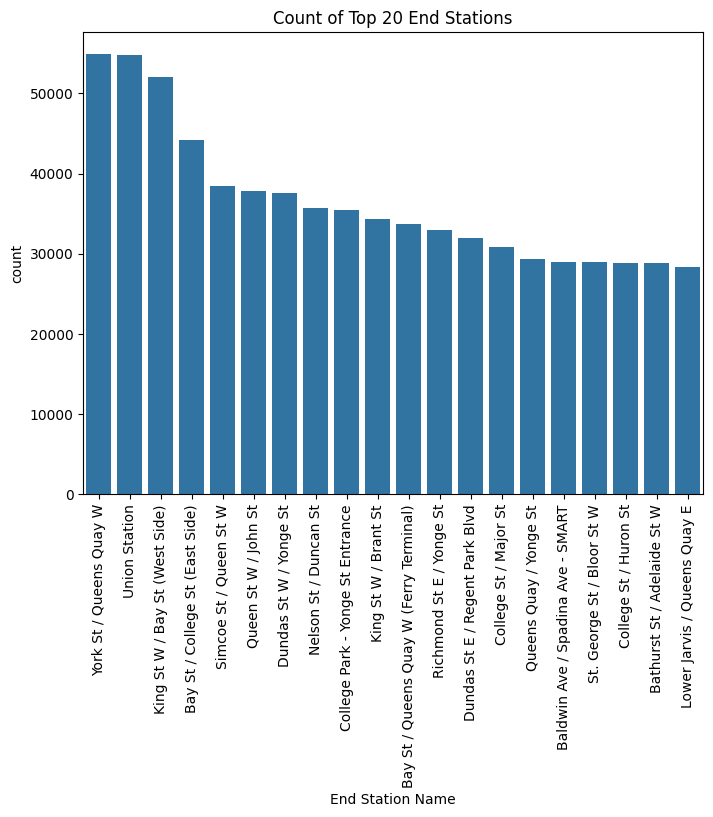

In [34]:
top_20_Stations = df['End Station Name'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top N categories
df_top_20 = df[df['End Station Name'].isin(top_20_Stations)]

# Create the countplot, ordering by frequency
plt.figure(figsize=(8, 6))
sns.countplot(data=df_top_20, x='End Station Name', order=top_20_Stations)
plt.title('Count of Top 20 End Stations')
plt.xticks(rotation='vertical')
plt.show()

In [35]:
df_diagnostic = df_new

# Converting some variables into integer (would be used in the diagnostic analysis)
df_diagnostic['Start Day'] = df_diagnostic['Start Day'].astype(int)
df_diagnostic['Start Month'] = df_diagnostic['Start Month'].astype(int)
df_diagnostic['End Day'] = df_diagnostic['End Day'].astype(int)
df_diagnostic['End Month'] = df_diagnostic['End Month'].astype(int)

# Convert 'Start Hour' into a numeric value
df_diagnostic['Start Hour'] = pd.to_datetime(df_diagnostic['Start Time'], format = '%H:%M', errors = 'coerce').dt.hour

#df_diagnostic.set_index('Trip Id')
# Index disappeared? Setting a new one with just the count
# ('Trip Id' no longer exists after the conversion to a list and the new ordering)

In [36]:
#df_pears = df_diagnostic
#
#df_pears.select_dtypes(int)
#sns.pairplot(df_pears)
#plt.show()

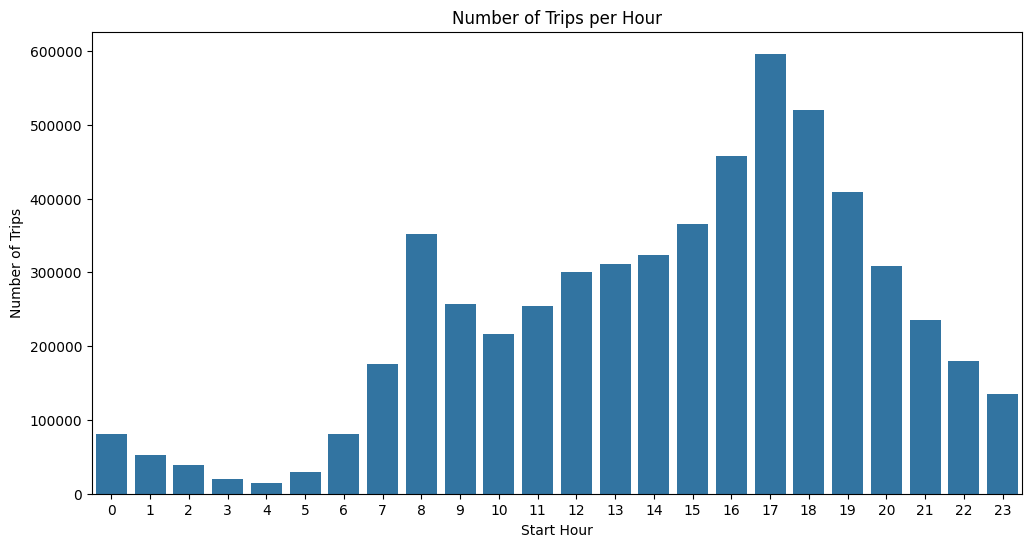

In [37]:
# Count the amount of rides per hour
hour_counts = df_diagnostic['Start Hour'].value_counts().sort_index()

# Create the bar plot and show the number of trips per hour
plt.figure(figsize=(12,6))
sns.barplot(x = hour_counts.index, y = hour_counts.values)
plt.title("Number of Trips per Hour")
plt.xlabel("Start Hour")
plt.ylabel("Number of Trips")
plt.show()

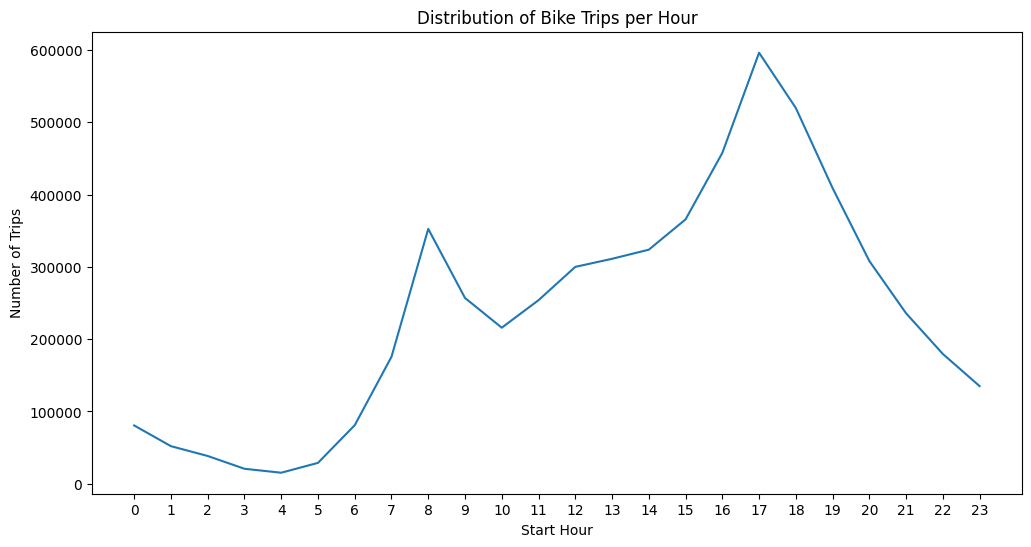

In [38]:
# Create a line plot and show the evolution of trips during each hour
plt.figure(figsize = (12,6))
sns.lineplot(data = df_diagnostic, x = 'Start Hour', y = 'Trip Duration', estimator = 'count', errorbar = None)
plt.xticks(range(24))
plt.title('Distribution of Bike Trips per Hour')
plt.ylabel('Number of Trips')
plt.show()

In [39]:
df_hour_week = pd.crosstab(df_diagnostic['Start Hour'], df_diagnostic['Weekday/Weekend'])
#df_hour_week = pd.crosstab(df_diagnostic['Start Hour'], df_diagnostic['Weekday/Weekend'], normalize = 'index') * 100
df_hour_week.sort_values(by = 'Weekday', ascending = False).round(2)

Weekday/Weekend,Weekday,Weekend
Start Hour,,
17,471530,124852
18,402474,117395
16,331357,126372
8,318983,33590
19,307379,101688
15,241234,124496
20,229571,78540
9,202308,54669
14,201824,121963


In [40]:
peak_hour_weekday = pd.crosstab(df['Peak Hour'], df['Weekday/Weekend'])
peak_hour_month = pd.crosstab(df['Peak Hour'], df['Start Month'])
peak_hour_weekday

Weekday/Weekend,Weekday,Weekend
Peak Hour,,
Evening,1752669,594113
Morning,746680,118812
Off Peak,1646985,848214


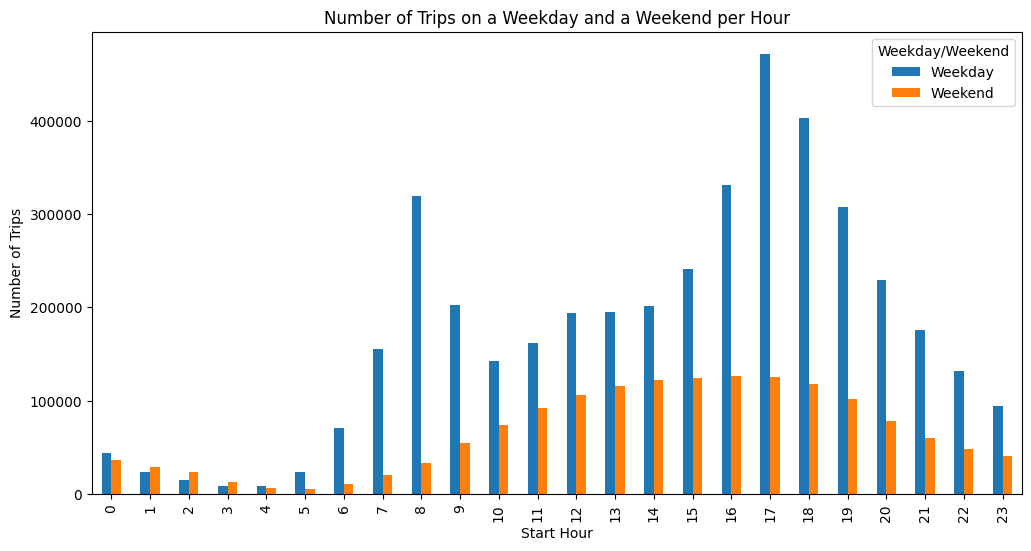

In [41]:
df_hour_week.plot(kind = 'bar', figsize=(12,6))
plt.title('Number of Trips on a Weekday and a Weekend per Hour')
plt.xticks(range(24))
plt.xlabel('Start Hour')
plt.ylabel('Number of Trips')
plt.show()

In [42]:
df_user_peak = pd.crosstab(df_diagnostic['User Type'], df_diagnostic['Start Hour'])
df_user_peak.transpose()

User Type,Annual Member,Casual Member
Start Hour,,
0,4215,76351
1,2780,49111
2,1800,36508
3,1201,19415
4,1110,14034
5,2627,26150
6,6503,74391
7,14720,160867
8,27750,324823


In [43]:
# Turn 'Peak Hour' into binary values
df_diagnostic['Peak Hour (Binary)'] = df_diagnostic['Peak Hour'].map({'Off Peak': 0, 'Morning': 1, 'Evening': 1})
df_diagnostic['Weekday/Weekend (Binary)'] = df_diagnostic['Weekday/Weekend'].map({'Weekend': 0, 'Weekday': 1})

In [44]:
# Calculated the correlation score for select variables using .corr()
df_correlation = df_diagnostic[['Trip Duration', 'Start Hour', 'Peak Hour (Binary)', 'Weekday/Weekend (Binary)']]
df_correlation.corr()

,Trip Duration,Start Hour,Peak Hour (Binary),Weekday/Weekend (Binary)
Trip Duration,1.000000,0.007977,-0.004647,-0.015138
Start Hour,0.007977,1.000000,0.030488,0.029260
Peak Hour (Binary),-0.004647,0.030488,1.000000,0.131297
Weekday/Weekend (Binary),-0.015138,0.029260,0.131297,1.000000


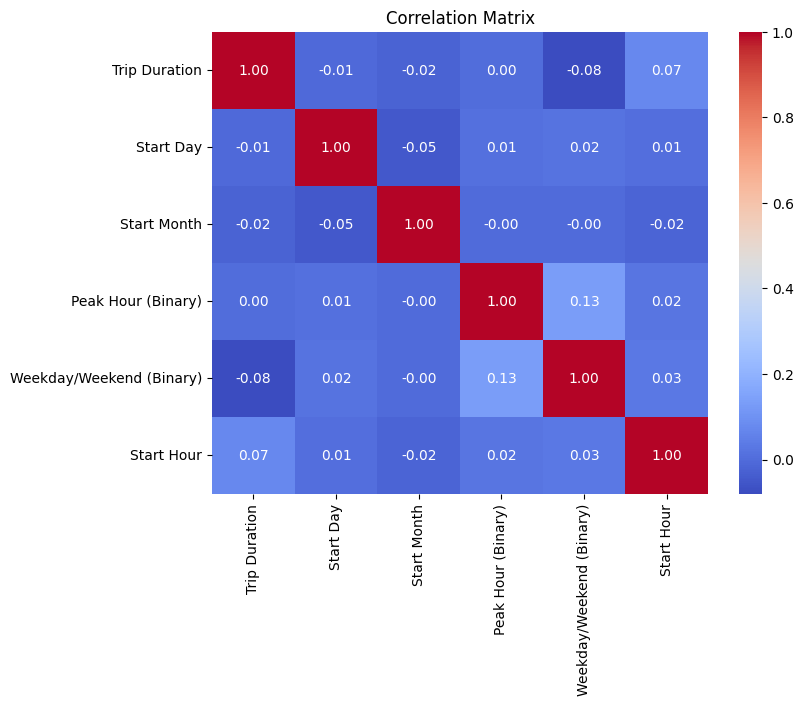

In [50]:
# Correlation analysis with a matrix
# Select relevant variables
numeric = ['Trip Duration', 'Start Day', 'Start Month', 'Peak Hour (Binary)', 'Weekday/Weekend (Binary)', 'Start Hour']
df_diagnostic['Trip Duration'] = df_diagnostic['Trip Duration'] / 60  # Convert to minutes
df_diagnostic = df_diagnostic[df_diagnostic['Trip Duration'] < 45] # Remove outliers 

# Calculating the correlation scores of the selected variables and assigning them to a data frame
correlation_matrix = df_diagnostic[numeric].corr()
correlation_matrix

# Plotting the Correlation Matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
df_diagnostic['Trip Duration'].sort_values(ascending = False)

Trip Id
22776891    44.983333
24226628    44.983333
25395541    44.983333
25447402    44.983333
23500587    44.983333
              ...    
21441973     0.000000
25591880     0.000000
26076629     0.000000
22728023     0.000000
26236011     0.000000
Name: Trip Duration, Length: 5491530, dtype: float64

In [ ]:
## Select relevant variables and drop missing values
#df_regression = df_diagnostic[['Trip Duration', 'Start Hour', 'Peak Hour','Weekday/Weekend', 'User Type']].dropna()
#df_regression['Trip Duration'] = df_regression['Trip Duration'] / 60  # Convert to minutes
#df_regression = df_regression[df_regression['Trip Duration'] < 45] # Remove outliers 
#
## Convert Trip Duration to numeric (forces errors to NaN, then drop them)
#df_regression['Trip Duration'] = pd.to_numeric(df_regression['Trip Duration'], errors='coerce')
#
## Convert categorical variables into a binary format (One-hot Encoding)
#df_regression = pd.get_dummies(df_regression, columns=['Start Hour', 'Peak Hour','Weekday/Weekend', 'User Type'], drop_first=True)
#
## Split X and y
#X = df_regression.drop(columns=['Trip Duration'])
#y = df_regression['Trip Duration']
#
## Force all X columns to float
#X = X.astype(float)
#y = y.astype(float)
#
## Add intercept for OLS
#X = sm.add_constant(X)
#
## Fit OLS model
#model = sm.OLS(y, X)
#results = model.fit()
#
## Show summary
#print(results.summary())

# Log transformation and remove outliers
# Specify which variables to pick for regression modeling: for Trip Duration and Peak Hour or Weekday (Can we predict if it is a weekday/commute based on trip duration? Any relationships?)
# Run NB: Quite a bit of categorical data that we can ask prediction for.
# PCA

In [ ]:
# naive bayes analysis

#remove all nulls

df_ml = df_diagnostic[['Trip Duration', 'Start Hour', 'Peak Hour (Binary)','Weekday/Weekend']].dropna()
df_ml['Trip Duration'] = df_ml['Trip Duration'] / 60  # Convert to minutes


# reset categorical variables
le=LabelEncoder()

for col in df_ml.columns:
    if df_ml[col].dtype == 'object':
        df_ml[col] = le.fit_transform(df_ml[col])
        

# create new variables for machine learning
x = df_ml.drop('Peak Hour (Binary)', axis=1) # features
y = df_ml['Peak Hour (Binary)'] # target

# split the data

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# select the model
model = MultinomialNB()

# train the model

model.fit(x_train, y_train)

# make predicitons
y_pred = model.predict(x_test)

In [ ]:
# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5817203948626339

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.32      0.40    478366
           1       0.60      0.79      0.68    619940

    accuracy                           0.58   1098306
   macro avg       0.57      0.55      0.54   1098306
weighted avg       0.57      0.58      0.56   1098306


Confusion Matrix:
 [[152109 326257]
 [133142 486798]]


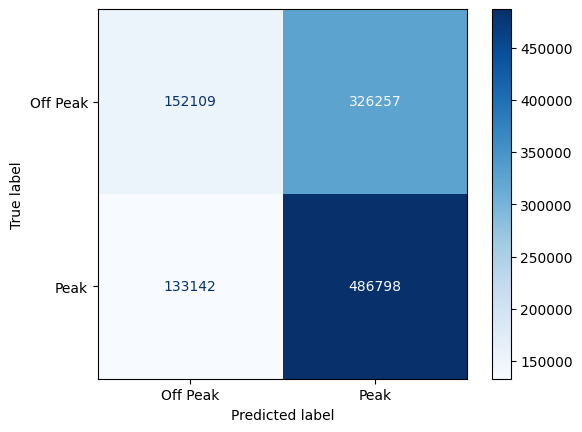

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# display

labels = ["Off Peak", "Peak"]  # set the labels

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap = 'Blues')

In [ ]:
#end of naive bayes work

In [ ]:
# Creating a new data frame for a logistic regression
# Removed 'Start Day'. 'Weekday/Weekend' already translated that into a binary system.
model_var = ['Peak Hour (Binary)', 'Weekday/Weekend (Binary)', 'Start Month']
df_model = df_diagnostic[model_var].copy()

categoricals = ['Start Month']

# Convert categorical variables into 'category' type
# If not present, Start Month is grouped into one predictor isntead of 12
for col in categoricals:
    df_model[col] = df_model[col].astype('category')

In [ ]:
df_model.info()
df_model.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5491530 entries, 20148784 to 26682738
Data columns (total 3 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   Peak Hour (Binary)        int64   
 1   Weekday/Weekend (Binary)  int64   
 2   Start Month               category
dtypes: category(1), int64(2)
memory usage: 130.9 MB


,Peak Hour (Binary),Weekday/Weekend (Binary),Start Month
Trip Id,,,
20148784,0,0,1
20148785,0,0,1
20148786,0,0,1
20148790,0,0,1
20148791,0,0,1


In [ ]:
X = pd.get_dummies(df_model.drop('Peak Hour (Binary)', axis=1), drop_first=True) # Drops January
X = X.astype(int) # Convert to integer to avoid a ValueError
y = df_model['Peak Hour (Binary)']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.675497
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:     Peak Hour (Binary)   No. Observations:              5491530
Model:                          Logit   Df Residuals:                  5491517
Method:                           MLE   Df Model:                           12
Date:                Sun, 23 Nov 2025   Pseudo R-squ.:                 0.01346
Time:                        20:47:14   Log-Likelihood:            -3.7095e+06
converged:                       True   LL-Null:                   -3.7601e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.1978      0.005    -39.265      0.000      -0.208

For weekday/weekend, the coeffieicnet is positive (0.6085). Using the logistic function, and after calculating the log-odds of each (Where Weekend = -0.252 and Weekday = 0.356), on a weekday, 59% of trips happen during peak hours and on a weekend, 44% of trips happen during peak hours. This means a weekday trip is more likely to occur during peak hour, compared to a weekend trip. P > |z| is close to 0 meaning the results are highly statistically significant (p-value smaller than 0.001).

Trips occuring in February, March, April, May, October and November have positive coefficients, meaning that trips occuring during peak hour are more likely to happen than January. June, July and December each have a negative coefficient, menaing that trips are less liley to happen during peak hour than Janaury. Fianlly, August and September both have coeffcient close to equal to 0, meaning they show little to no differences with January. We can infer that there is a seasonal pattern, with lower peak hour riderships during summer, and an increased peak hour ridership in the spring and late fall.

In [ ]:
df_diagnostic.columns

Index(['Trip Duration', 'Start Station Id', 'Start Time', 'End Date',
       'End Day', 'End Month', 'Start Day', 'Start Month', 'Start Date',
       'Start Station Name', 'End Station Id', 'End Time', 'End Station Name',
       'User Type', 'Weekday/Weekend', 'Trip Duration (mm:ss)', 'Peak Hour',
       'Start Hour', 'Peak Hour (Binary)', 'Weekday/Weekend (Binary)'],
      dtype='object')

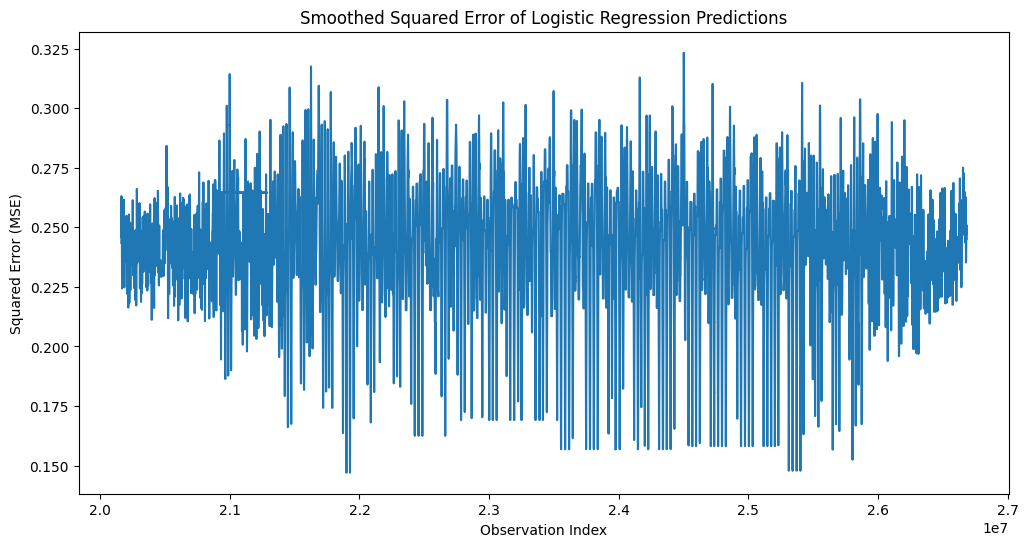

Overall MSE: 0.2412


In [ ]:
y_predicted_probability = model.predict(X) # Predicted probabilities
squared_errors = (y - y_predicted_probability) ** 2 # Squared errors

# Compute rolling mean to visualize MSE pattern and smooth it
mse_smoothed = pd.Series(squared_errors).rolling(window = 10000).mean()

plt.figure(figsize=(12,6))
plt.plot(mse_smoothed)
plt.xlabel('Observation Index')
plt.ylabel('Squared Error (MSE)')
plt.title('Smoothed Squared Error of Logistic Regression Predictions')
plt.show()

mse_total = np.mean(squared_errors)
print(f"Overall MSE: {mse_total:.4f}")

In [ ]:
df_duration = df_diagnostic.copy()

#df_duration = df_duration[df_duration['Trip Duration'] > 0] # Remove trips that have a duration of 0
#df_duration = df_duration[df_duration['Trip Duration'] < 14400] # Remove trips that exceed 4 hours

# Remove outliers
upper_limit = df_duration['Trip Duration'].quantile(0.99)
df_duration = df_duration[df_duration['Trip Duration'] <= upper_limit]

# Log transform duration
df_duration['Log_Trip_Duration'] = np.log1p(df_duration['Trip Duration'])

bins = [0, 300, 900, 1800, 14400]
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
df_duration['Trip_Duration_Category'] = pd.qcut(df_duration['Trip Duration'], q = 5, labels  =labels)

columns_kept = ['Trip Duration', 'Log_Trip_Duration', 'Trip_Duration_Category', 'Weekday/Weekend (Binary)', 
                'Start Month', 'Start Day', 'Peak Hour (Binary)']

df_duration = df_duration[columns_kept]

df_duration.sample(10)

,Trip Duration,Log_Trip_Duration,Trip_Duration_Category,Weekday/Weekend (Binary),Start Month,Start Day,Peak Hour (Binary)
Trip Id,,,,,,,
20713324,8.433333,2.244250,Short,1,3,22,0
25734071,4.450000,1.695616,Very Short,0,10,21,1
23079619,10.316667,2.426277,Medium,0,7,15,1
25087556,18.333333,2.961831,Long,0,9,24,1
25579863,25.283333,3.268935,Very Long,0,10,14,1
26377568,5.200000,1.824549,Very Short,1,11,29,1
22291207,18.866667,2.989043,Long,1,6,15,0
26304298,11.583333,2.532373,Medium,1,11,23,1
21299565,5.816667,1.919371,Very Short,1,5,4,1


In [ ]:
df_duration['Trip_Duration_Category'].value_counts()

Trip_Duration_Category
Very Short    1090477
Short         1089042
Long          1087888
Very Long     1085451
Medium        1083936
Name: count, dtype: int64

In [ ]:
# Tried to run a regression model later with the Start and End Station Ids but it crashed my kernel. 
# But i do plan on making it work since ignoring it is not a good idea. noticed that it does impact trip duration and peak hour

# Bike as a mode of convenience: bike is preferred usually. 
# We found a lot of correlation and pattern of usage, but, none of the data we found is predictive... for example
# to do more predictive analysis

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Copy the dataset
df_pred = df_duration.copy()

# One-hot encode categorical features
categorical_features = ['Start Month', 'Start Day', 'Weekday/Weekend (Binary)']
X = pd.get_dummies(df_pred[categorical_features], drop_first=True)

# Include continuous features
#X['Trip Duration'] = df_pred['Trip Duration']
X['Log_Trip_Duration'] = df_pred['Log_Trip_Duration']

# Target
y = df_pred['Peak Hour (Binary)']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Add constant for Logit
X_train_const = sm.add_constant(X_train).astype(float)
X_test_const = sm.add_constant(X_test).astype(float)

# Fit Logit model (train set)
model = sm.Logit(y_train, X_train_const).fit()
print(model.summary())

# Make predictions (test set)
y_prob = model.predict(X_test_const)
y_pred = (y_prob >= 0.5).astype(int)

# Evaluate predictive performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Optimization terminated successfully.
         Current function value: 0.675295
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:     Peak Hour (Binary)   No. Observations:              3805755
Model:                          Logit   Df Residuals:                  3805750
Method:                           MLE   Df Model:                            4
Date:                Sun, 23 Nov 2025   Pseudo R-squ.:                 0.01362
Time:                        21:17:02   Log-Likelihood:            -2.5700e+06
converged:                       True   LL-Null:                   -2.6055e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.3836      0.006    -64.632      0.000      -0.395